# Using LSTM to conduct regression predict

#### First, generate sample of a time series.

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt


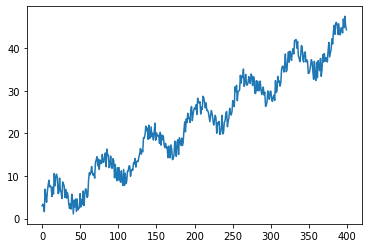

In [2]:
# generate a Sinewave
N=400
n=np.arange(N)
mydata = n/10 + 4*np.sin(n/10) + 5*np.random.rand(N)
plt.figure()
plt.plot(mydata)

#### recreate the data data so that it meets the requrement of shape for lstm learning later

- define a kernel with size of step
- move this kernal through the data set, and generate x and y data for lstm training

In [43]:
# reshape the input data
step = 2


def reOrgData(mydata, step):

    N = len(mydata)
    time_series = np.zeros((len(mydata)+1,))
    time_series[0:len(mydata)] = mydata
    time_series[-1] = mydata[-1]  # replicate the last value in time_series

    # get the first x data for training
    my_x = time_series[0:step].reshape((1,step))   # reshape it to size (step, 1)
    my_y = [time_series[step]]

    for n in range(1, N):   # you already get the first x data above
        mew_new_x = time_series[n: n+step].reshape((1,step))   # reshape it to size (step, 1)
        my_x = np.concatenate((my_x, mew_new_x), axis=0) # concantenate data along row

        if n+step<N-1:       my_y.append(time_series[n+step])
        elif n+step>=N-1: my_y.append(time_series[n+step-1])  # for the last y, just replicate the data point

    # reshape y data
    my_y = np.asarray(my_y).reshape((len(my_y),1))
    
    return(my_x, my_y)

my_x, my_y = reOrgData(mydata, step)


# reformat the data with training y data concatenate to x data
x_train = np.concatenate((my_x, my_y), axis=1) # concantenate data along column

print(my_x.shape)
print(my_y.shape)
print(x_train.shape)


(400, 2)
(400, 1)
(400, 3)


### Use tensorflow lstm layer to build the model

In [44]:
# import related modules
import tensorflow as tf
print("tensorflow version: " + tf.__version__)  # look at what version of tensorflow that I have
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
import os
directory =os.getcwd()  # get current working directory


tensorflow version: 2.0.0


#### Build a lstm based recurrent neural network model
This section defines the model structure

In [45]:
# build a learning decay schedule, use this during optimizer building.
'''
More info for exponetial decay:
https://www.tensorflow.org/api_docs/python/tf/compat/v1/train/exponential_decay
'''

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(  # use exponetial learning rate decay during training
    initial_learning_rate= 0.01,
    decay_steps=100,  # decay the learning rate every given decay_steps
    decay_rate=0.96,  # every time for decay learning rate, decay with decay_rate of exponential decay base.
    staircase=False)


'''
Build a simgple LSTM model
use a unidirectional lstm layer, not bidirectional
'''
NUM_SCALES = 1
input_shape = (step, NUM_SCALES)
hidden_size = 128

initializer = tf.initializers.VarianceScaling(scale=2.0)
regularizer = tf.keras.regularizers.l2(0.02)
layers = [   
    tf.keras.layers.LSTM(input_shape=input_shape,
                         units = hidden_size,
                         #kernel_initializer=initializer,
                         #kernel_regularizer=regularizer,
                         #return_sequences=True,  # output in the sequence
                         activation='relu'
                        ),                
        
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dense(1, activation='linear'),
    
    ]

model = tf.keras.Sequential(layers)




model.compile(optimizer="Adam", loss="mse", metrics=["mae"])

tensorboard_cbk = tf.keras.callbacks.TensorBoard(
                              log_dir=directory,    # directory where to write logs
                              histogram_freq=0,     # How often to log histogram visualizations
                              embeddings_freq=0,    # How often to log embedding visualizations
                              update_freq='epoch')  # How often to write logs (default: once per epoch)
# print the model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 76,929
Trainable params: 76,929
Non-trainable params: 0
_________________________________________________________________


#### Conduct training and testing
#### Plot some figures to see

In [46]:
# reshape the data for training 
x_train = np.reshape(my_x, (my_x.shape[0], my_x.shape[1] ,1)) # (num, step, 1)
y_train = my_y

print(x_train.shape)


(400, 2, 1)


In [47]:

num_epoches = 50
model.fit(x_train, y_train, batch_size=32, epochs=num_epoches, shuffle=False)    # use tensorboard call back to visualize the training process

Train on 400 samples
Epoch 1/50
400/400 [==============================] - 1s 4ms/sample - loss: 494.7494 - mae: 20.1224
Epoch 2/50
400/400 [==============================] - 0s 167us/sample - loss: 111.5287 - mae: 9.8668
Epoch 3/50
400/400 [==============================] - 0s 112us/sample - loss: 97.0990 - mae: 8.1720
Epoch 4/50
400/400 [==============================] - 0s 150us/sample - loss: 81.6059 - mae: 7.5652
Epoch 5/50
400/400 [==============================] - 0s 115us/sample - loss: 10.2794 - mae: 2.7225
Epoch 6/50
400/400 [==============================] - 0s 162us/sample - loss: 10.3922 - mae: 2.5946
Epoch 7/50
400/400 [==============================] - 0s 97us/sample - loss: 9.1885 - mae: 2.4882
Epoch 8/50
400/400 [==============================] - 0s 145us/sample - loss: 5.2565 - mae: 1.8498
Epoch 9/50
400/400 [==============================] - 0s 112us/sample - loss: 3.9834 - mae: 1.6296
Epoch 10/50
400/400 [==============================] - 0s 152us/sample - loss: 3.7

In [50]:
# generate new data, and conduct prediction
N=800
n=np.arange(N)
mydata2 = n/10 + 4*np.sin(n/10) + 5*np.random.rand(N)

my_x2, my_y2 = reOrgData(mydata2, step)
# reformat the data with training y data concatenate to x data
#x_train2 = np.concatenate((my_x2, my_y2), axis=1) # concantenate data along column

x_train2 = np.reshape(my_x2, (my_x2.shape[0], my_x2.shape[1] ,1)) # (num, step, 1)
y_train2 = my_y2

y_pred = model.predict(x_train2)
scores = model.evaluate(x_train2, y_train2, verbose = 0)
print("loss: " + str(scores[0]) )
print("mean absolute error: " + str(scores[1]) )

loss: 3.9817944049835203
mean absolute error: 1.6253636


a single point prediction is: [[57.401524]]


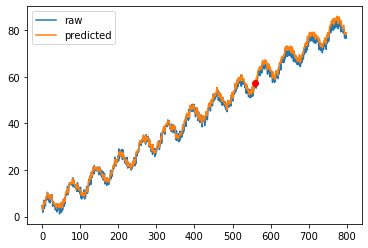

In [51]:
plt.figure()
plt.plot(mydata2)
plt.plot(y_pred)
plt.legend(["raw","predicted"])


# conduct a single point prediction
loc = 560
a_single_data = np.reshape(x_train2[loc,:,:], (1,step,1) )
y_pred_single = model.predict(a_single_data)

plt.plot(loc, y_pred_single[0], 'ro')

print("a single point prediction is: " + str(y_pred_single))
